# Chapter 15: Processing Sequences Using RNNs and CNNs

## Setup

In [17]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA

import tensorflow as tf
from tensorflow import keras
from keras import (
    utils
)

## Forecasting a Time Series

In [2]:
path = Path("../../datasets/chapter_15/cta_dataset.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]
df = df.sort_values("date").set_index("date") # Sort the data by the column date
df = df.drop("total", axis=1) # No need for total, it's just bus + rail
df = df.drop_duplicates() # remove duplicated months

In [3]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


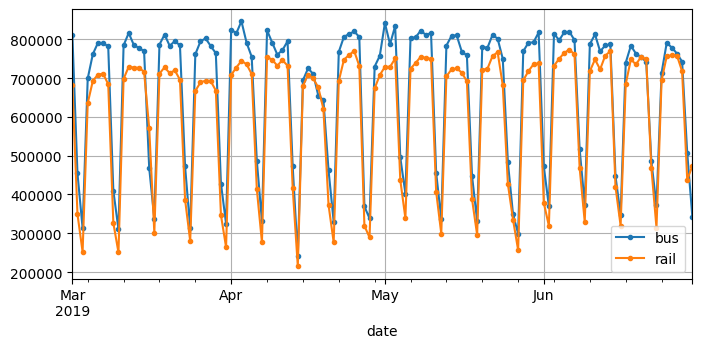

In [4]:
df["2019-03":"2019-06"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

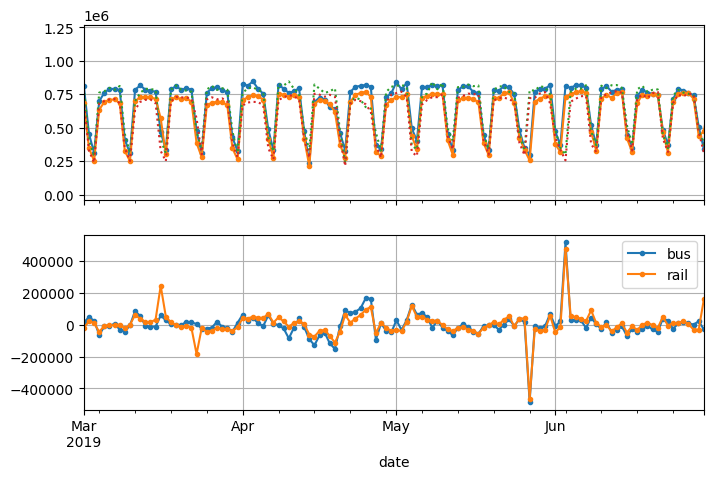

In [5]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-06"]

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=ax[0], legend=False, marker=".")
df.shift(7).plot(ax=ax[0], grid=True, legend=False, linestyle=":")
diff_7.plot(ax=ax[1], grid=True, marker=".")
plt.show()

In [6]:
list(df.loc["2019-05-25":"2019-05-30"]["day_type"])

['A', 'U', 'U', 'W', 'W', 'W']

Let's calculate the Mean Absolute Error 
$$MAE=\frac{1}{n}\sum_{i=1}^{n}{|Y_i-\hat{Y_i}|}$$

In [7]:
diff_7.abs().mean()

bus     43454.450820
rail    42706.385246
dtype: float64

Now, let's calculate the *Mean Absolute Percentage Error* (MAPE):

$$MAE=\frac{1}{n}\sum_{i=1}^{n}\frac{|Y_i-\hat{Y_i}|}{Y_i}$$

In [8]:
targets = df[["bus", "rail"]]["2019-03":"2019-06"]
(diff_7/targets).abs().mean()

bus     0.078124
rail    0.086282
dtype: float64

Let's plot the data from 2001 to 2019 to find any possible yearly seasonality:

/var/folders/bs/jxzw14n53ksgt9_q98rq0_0m0000gn/T/ipykernel_19518/2133097612.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_monthly = df.resample("M").mean()


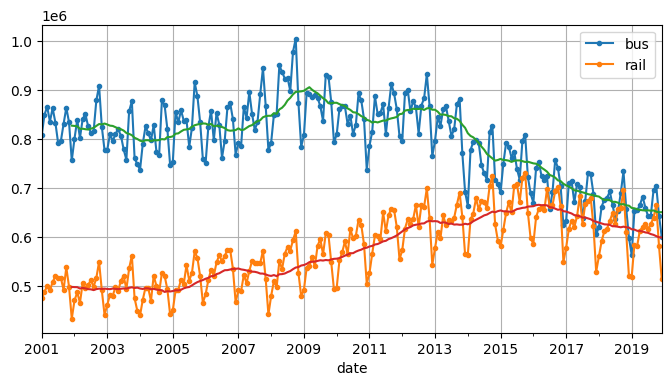

In [9]:
period = slice("2001", "2019")
df_monthly = df.resample("M").mean()
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()

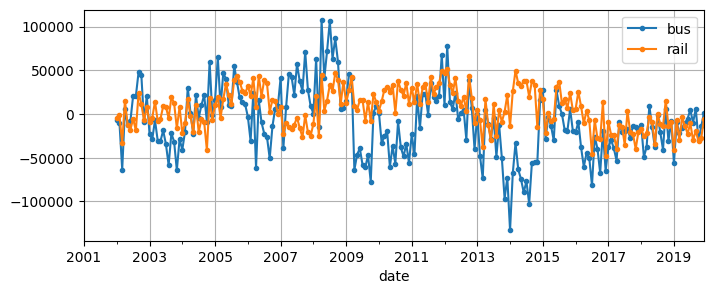

In [10]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
plt.show()

## The ARMA Model Family

$$\hat{y_(t)} = \sum_{i=1}^{p}{a_{i}y_{(t-i)}} + \sum_{i=1}^{q}{\theta_{i}\epsilon_{(t-i)}}$$
$$\text{with }\epsilon_{(t-i)} = y_{(t)}-\hat{y}_{(t)}$$

Let's fit a SARIMA model with the same time series:

In [11]:
origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(
    rail_series,
    order=(1, 0, 0),
    seasonal_order=(0, 1, 1, 7)
)
model = model.fit()
y_pred = model.forecast()

In [12]:
y_pred

2019-06-01    427758.62629
Freq: D, dtype: float64

Calculate the `MAE` over the months of March, April and May:

In [14]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(
        rail_series[origin:today],
        order=(1, 0, 0),
        seasonal_order=(0, 1, 1, 7)
    )
    model = model.fit()
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()
mae

32040.72009335344

## Preparing the Data for Machine Learning Models

In [18]:
my_series = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
my_dataset = utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],
    sequence_length=3, 
    batch_size=2
)

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



In [19]:
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[2, 3, 4],
         [3, 4, 5]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([5, 6], dtype=int32)>),
 (<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[4, 5, 6],
         [5, 6, 7]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([7, 8], dtype=int32)>),
 (<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[6, 7, 8],
         [7, 8, 9]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([ 9, 10], dtype=int32)>)]

In [21]:
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True):
    for element in window_dataset:
        print(f"{element}", end="")
    print()

0123
1234
2345
